# Setting 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import bisect

In [3]:
from scipy.signal import argrelextrema
from statsmodels.nonparametric.smoothers_lowess import lowess
#import matrixProfile
from dtw import *

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [4]:
from tqdm import tqdm

In [5]:
import following_motif_method.matrixProfile as matrixProfile

# Visualization

In [6]:
def ts_visualization(ts, label='Time Series',color="blue",size=(15, 10)):
  plt.figure(figsize=size)
  plt.subplot(2, 1, 1)
  plt.title(label)
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.grid()
  plt.plot(ts, label=label, color=color)

In [7]:
def leadfollow_visualization(ts1,ts2,size=(15, 10)):
  plt.figure(figsize=size)
  plt.subplot(2, 1, 1)
  plt.title('Leading Time Series')
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.grid()
  plt.plot(ts1, label='Leading signal', color='blue')
  plt.subplot(2, 1, 2)
  plt.title('Following Time Series')
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.grid()
  plt.plot(ts2, label='Following signal', color='red')
  plt.show()

In [8]:
def highlight_follow_area(input_array,highlight_index_array, highlight_values,discord_highlight_index_array, discord_highlight_values,title):
    plt.figure(figsize=(10, 5))

    plt.plot(input_array, label='Time Series', marker='o')
    plt.scatter(highlight_index_array, highlight_values, color='red', zorder=5, label='Highlighted motif')
    plt.scatter(discord_highlight_index_array, discord_highlight_values, color='green', zorder=5, label='Highlighted discord')

    # Additional plot settings
    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()

    plt.show()

In [9]:
def alignment_plot(result,lead_ts,follow_ts):
    # Sample data
    x1 = np.linspace(0,1,len(result[0]["new_index_lead"]))
    y1 = lead_ts[result[0]["new_index_lead"]]

    x2 = np.linspace(0,1, len(result[0]["new_index_follow"]))
    y2 = follow_ts[result[0]["new_index_follow"]]

    x3 = result[0]["new_index_lead"]
    y3 = result[0]["new_index_follow"]

    # Create a figure with custom subplot layout
    fig = plt.figure(figsize=(10, 10))

    # Add subplots in specified positions [left, bottom, width, height]
    ax1 = fig.add_axes([0.05, 0.55, 0.3, 0.6])  # Reference Index (top left)
    ax2 = fig.add_axes([0.55, 0.05, 0.7, 0.4])  # Query Index (bottom right)
    ax3 = fig.add_axes([0.55, 0.55, 0.7, 0.6])  # Square box (top right)

    # Plot data on each subplot
    ax1.plot(y1, x1)
    ax1.set_ylabel('Leader TimeSeries')
    ax1.set_xticks([])  # Hide x-axis ticks for the first plot

    ax2.plot(x2, y2)
    ax2.set_xlabel('Following TimeSeries')

    ax3.plot(y3, x3)

    # Show the plots
    plt.show()

In [10]:
def alignment_plot(lead_ts,follow_ts,new_index_lead,new_index_follow):

    y1 = lead_ts[new_index_lead]
    y2 = follow_ts[new_index_follow]
    

    gap = len(new_index_lead)-len(new_index_follow)
    if gap<0:
        print(fr"lead small: {gap}")
    else: 
        print(fr"lead big  : {gap}")
        follow_ts

# Dataset

In [11]:
def leading_ts1(randseed=0,k_motif=2,varied_len=False,one_motif=False):

  np.random.seed(randseed)

  #-------------------------------------------------------------------------------------------

  if varied_len:

    high = 1000
    N = np.random.randint(int(0.1*high),high=high)

    motif_start_list   = [0]
    discord_start_list = [0]

    while (motif_start_list[-1]<N) and (discord_start_list[-1]<N):
     
      # motif length
      motif_length   = np.random.randint(int(N*0.025),high=int(N*0.1))

      # discord length
      discord_length = int(motif_length*5)
      while (N%(discord_length+motif_length) != 0) and (discord_length>int(N*0.6)): discord_length += 1

      #new motif and discord start
      discord_start_list.append(motif_start_list[-1]+motif_length)
      motif_start_list.append(discord_start_list[-1]+discord_length)

    discord_start_list = discord_start_list[1:]
    if motif_start_list[-1] > N:
      motif_start_list = motif_start_list[:-1]
      if discord_start_list[-1] > N:
        discord_start_list = discord_start_list[:-1]

  else:
    N = 1000

    if one_motif:
      motif_length   = np.random.randint(int(N*0.1),high=int(N*0.15))
      discord_length = int(motif_length*5)
      motif_start_list   = [int(N*np.random.randint(int(15),high=int(30))/100)+motif_length]

    else:
      motif_length   = np.random.randint(int(N*0.025),high=int(N*0.1))
      discord_length = int(motif_length*1.2)
      motif_start_list   = [i for i in range(0,N,int(motif_length+discord_length))]

  t = np.arange(N)
  time_series = np.zeros(N)

  #-------------------------------------------------------------------------------------------

  n = 0
  i = 0
  motif = [[np.random.randint(low=2,high=10)/10,np.random.randint(low=300,high=500)/100] for i in range(k_motif)]
  #motif = [[np.random.randint(low=2,high=10)/10,np.random.randint(low=300,high=500)/10] for i in range(k_motif)]

  if motif_start_list[0] != 0:
    time_series[0:motif_start_list[0]] += (np.random.normal(0, 0.5,len(time_series[0:motif_start_list[0]])))

  while n<len(motif_start_list):
    if k_motif <= 1: i = 0
    try:
      time_series[motif_start_list[n]:motif_start_list[n]+motif_length] += np.sin(motif[i][0] * np.pi * t[:motif_length]/motif[i][1])
    except ValueError:
      time_series[motif_start_list[n]:N] += np.sin(motif[i][0] * np.pi * t[:int(N-motif_start_list[n])]/motif[i][1])
      break

    try:
      time_series[motif_start_list[n]+motif_length:motif_start_list[n+1]] += (np.random.normal(0, 0.5, discord_length))
    except IndexError:
      time_series[motif_start_list[n]+motif_length:N] += (np.random.normal(0, 0.5, (N-motif_start_list[n]-motif_length)))

    n += 1
    i += 1
    if i == len(motif): i = 0

  #-------------------------------------------------------------------------------------------

  time_series += (np.random.normal(0, 0.1, N))
  #time_series += (np.random.normal(0, 0.1, N))

  #-------------------------------------------------------------------------------------------
  if not varied_len:
    motif_interval = [[x for x in motif_start_list],[x+motif_length for x in motif_start_list]]
    

    return (time_series, motif_interval)

  return time_series

[[344], [488]]


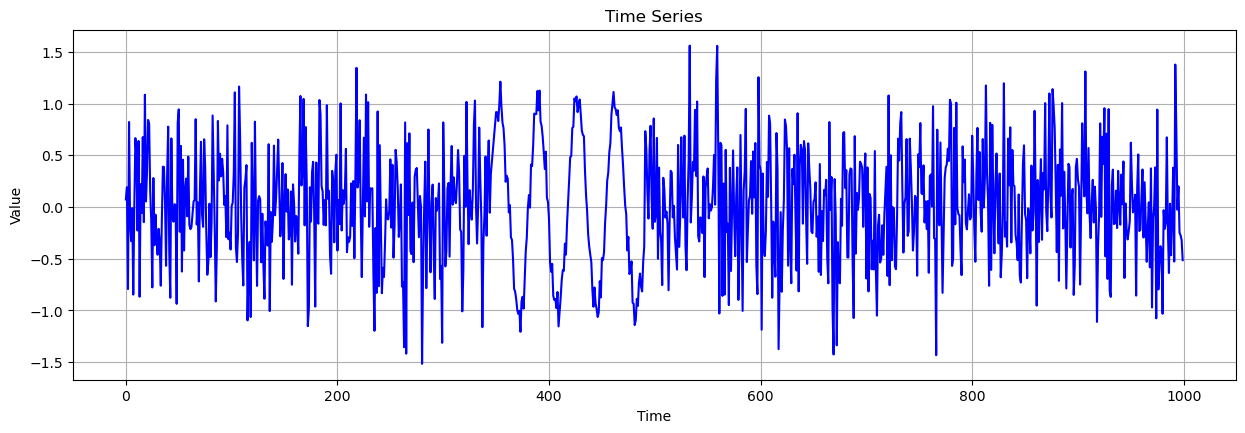

In [12]:
i = 0 
leader_list_1   = leading_ts1(randseed=i,k_motif=1,varied_len=False,one_motif=True)
ts_visualization(leader_list_1[0])
print(leader_list_1[1])

In [13]:
def following_ts1(leading_ts,randseed=0,uncontinuous=True,ground_truth=False):

  np.random.seed(randseed)

  leading_signal = leading_ts[0].copy()
  N              = (leading_signal.shape)[0]
  percent        = np.random.randint(low=20,high=35)/100
  N_first_signal = int(np.ceil(N*percent))
  N_follow       = N - N_first_signal

  degree_of_noise = 3
  noise = 0.5

  first_signal = np.random.normal(0, noise, N_first_signal)

  #leader interval
  lead_motif_start = list(leading_ts[1][0])
  lead_motif_stop  = list(leading_ts[1][1])

  motif_start,motif_stop = [],[]

  #following time series generating
  if uncontinuous:

    time_series = np.zeros(N)
    cutting_point = int(len(time_series)/2)

    percent        = np.random.randint(low=10,high=15)/100
    second_N       = int(len(time_series)*percent)

    interrupt = True

    for t in range(N):
      lag = np.random.randint(0, min(t, degree_of_noise) + 1)
      time_series[t] = leading_signal[t - lag]

      if t in lead_motif_start:
        if t<cutting_point:
          motif_start.append(t+N_first_signal)
        else:
          motif_start.append(t+N_first_signal+second_N)

      if t in lead_motif_stop:
        if t<cutting_point:
          motif_stop.append(t+N_first_signal)
        elif (t in range(cutting_point,cutting_point+second_N+1)) and interrupt:
          motif_stop.append(cutting_point+N_first_signal)
          interrupt = False
        else:
          motif_stop.append(second_N+N_first_signal+t)

    time_series1 = time_series[:cutting_point]
    time_series2 = time_series[cutting_point:]

    percent        = np.random.randint(low=10,high=15)/100
    second_signal = np.random.normal(0, noise, second_N)

    time_series = np.hstack((first_signal,time_series1,second_signal,time_series2))[:N]

  else:
    time_series = np.zeros(N)
    for t in range(N):
      lag = np.random.randint(0, min(t, degree_of_noise) + 1)
      time_series[t] = leading_signal[t - lag]

      if t in lead_motif_start:
        motif_start.append(t+N_first_signal)
      if t in lead_motif_stop:
        motif_stop.append(t+N_first_signal)

    time_series = np.hstack((first_signal,time_series))[:N]

  # adding noise
  time_series += np.random.normal(0, 0.05, N)
  #time_series += (np.random.normal(0, 0.1, N))

  #motif_interval
  motif_start = [x for x in motif_start if x<N]
  motif_stop = [x for x in motif_stop if x<N]

  motif_interval = [motif_start[:len(motif_stop)],motif_stop]
  #print(motif_interval)

  if ground_truth:
    motif_start = motif_start[:len(motif_stop)]

    keys   = list(range(len(motif_start)))
    values = []
    for i in range(len(motif_start)):
      pair_result = {
          "leader_interval" : [lead_motif_start[i],lead_motif_stop[i]],
          "follower_interval":[motif_start[i],motif_stop[i]]
      }
      values.append(pair_result)
    result = dict(zip(keys,values))

    return (time_series, result)

  return (time_series, motif_interval)

[[664], [808]]


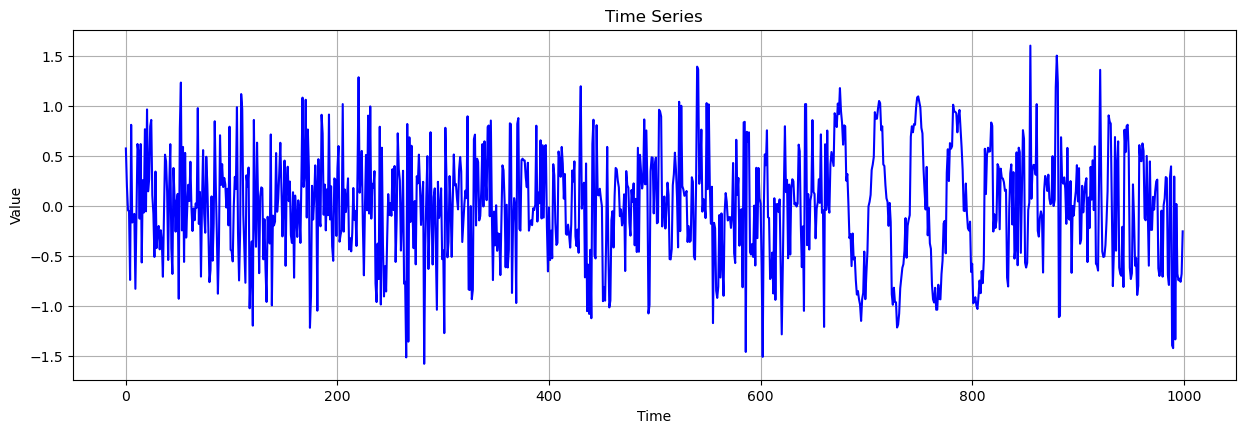

In [14]:
i = 0 
follower_list_1 = following_ts1(leader_list_1,randseed= i,uncontinuous=False) 
ts_visualization(follower_list_1[0])
print(follower_list_1[1])

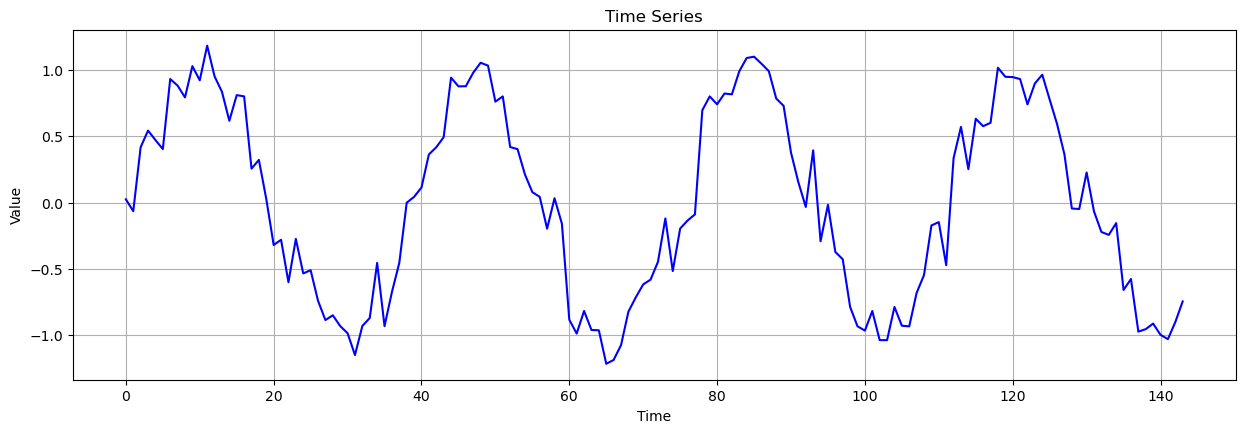

In [15]:
ts_visualization(follower_list_1[0][664:808])

In [16]:
def leading_ts(randseed=0,k_motif=2,varied_len=False,one_motif=False):

  np.random.seed(randseed)

  #-------------------------------------------------------------------------------------------

  if varied_len:

    high = 1000
    N = np.random.randint(int(0.1*high),high=high)

    motif_start_list   = [0]
    discord_start_list = [0]

    while (motif_start_list[-1]<N) and (discord_start_list[-1]<N):
     
      # motif length
      motif_length   = np.random.randint(int(N*0.025),high=int(N*0.1))

      # discord length
      discord_length = int(motif_length*5)
      while (N%(discord_length+motif_length) != 0) and (discord_length>int(N*0.6)): discord_length += 1

      #new motif and discord start
      discord_start_list.append(motif_start_list[-1]+motif_length)
      motif_start_list.append(discord_start_list[-1]+discord_length)

    discord_start_list = discord_start_list[1:]
    if motif_start_list[-1] > N:
      motif_start_list = motif_start_list[:-1]
      if discord_start_list[-1] > N:
        discord_start_list = discord_start_list[:-1]

  else:
    N = 1000

    if one_motif:
      motif_length   = np.random.randint(int(N*0.1),high=int(N*0.15))
      discord_length = int(motif_length*5)
      motif_start_list   = [int(N*np.random.randint(int(15),high=int(30))/100)+motif_length]

    else:
      motif_length   = np.random.randint(int(N*0.025),high=int(N*0.1))
      discord_length = int(motif_length*1.2)
      motif_start_list   = [i for i in range(0,N,int(motif_length+discord_length))]

  # ground truth 
  #print(motif_start_list)

  t = np.arange(N)
  time_series = np.zeros(N)

  #-------------------------------------------------------------------------------------------

  n = 0
  i = 0
  motif = [[np.random.randint(low=2,high=10)/10,np.random.randint(low=300,high=500)/100] for i in range(k_motif)]

  if motif_start_list[0] != 0:
    time_series[0:motif_start_list[0]] += (np.random.normal(0, 0.5,len(time_series[0:motif_start_list[0]])))

  while n<len(motif_start_list):
    factor = np.random.randint(low=1,high=7)
    if k_motif <= 1: i = 0
    try:
      time_series[motif_start_list[n]:motif_start_list[n]+motif_length] += np.sin(motif[i][0] * np.pi * t[:motif_length]/motif[i][1])
    except ValueError:
      time_series[motif_start_list[n]:N] += np.sin(motif[i][0] * np.pi * t[:int(N-motif_start_list[n])]/motif[i][1])
      break

    try:
      time_series[motif_start_list[n]+motif_length:motif_start_list[n+1]] += (np.random.normal(0, 0.5, discord_length))*factor
    except IndexError:
      time_series[motif_start_list[n]+motif_length:N] += (np.random.normal(0, 0.5, (N-motif_start_list[n]-motif_length)))*factor

    n += 1
    i += 1
    if i == len(motif): i = 0

  #-------------------------------------------------------------------------------------------

  time_series += (np.random.normal(0, 0.1, N))

  #-------------------------------------------------------------------------------------------
  if not varied_len:
    motif_interval = [[x for x in motif_start_list],[x+motif_length for x in motif_start_list]]
     
    return (time_series, motif_interval)

  return time_series

[[0, 151, 302, 453, 604, 755, 906], [69, 220, 371, 522, 673, 824, 975]]


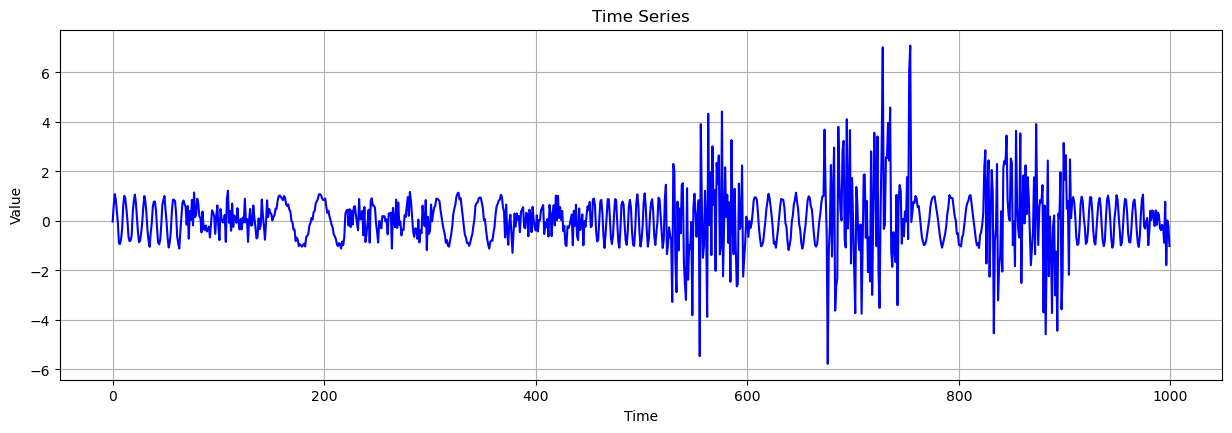

In [17]:
i = 0 
leader_list_1   = leading_ts(randseed=i,k_motif=10,varied_len=False)    
ts_visualization(leader_list_1[0])
print(leader_list_1[1])

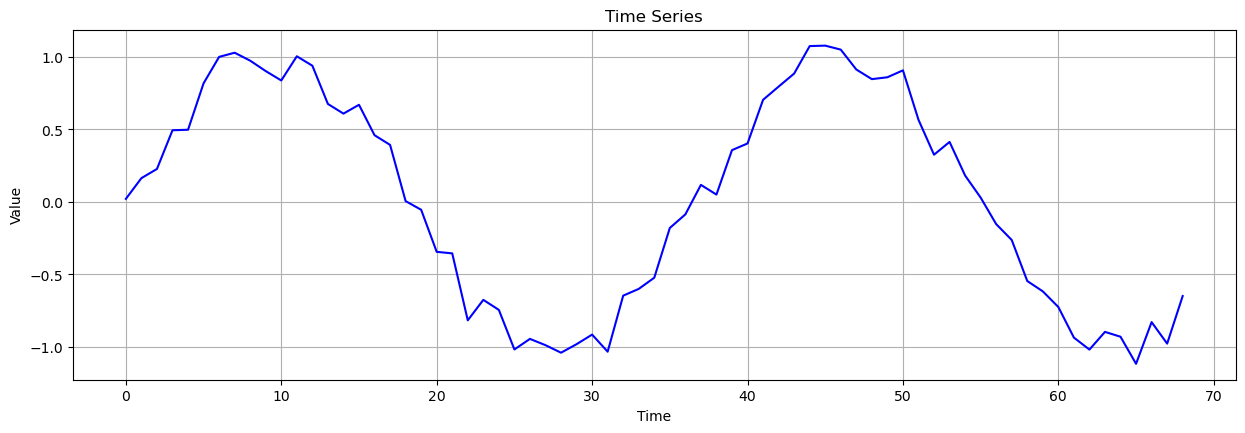

In [18]:
ts_visualization(leader_list_1[0][151:220])

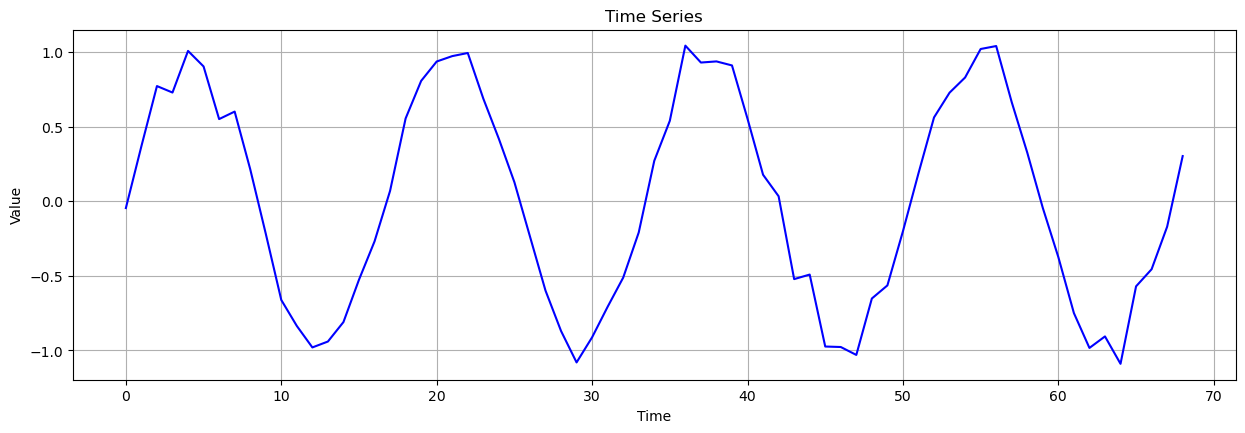

In [19]:
ts_visualization(leader_list_1[0][755:824])

In [20]:
def following_ts(leading_ts,randseed=0,uncontinuous=True,ground_truth=False):

  np.random.seed(randseed)

  leading_signal = leading_ts[0].copy()
  N              = (leading_signal.shape)[0]
  percent        = np.random.randint(low=20,high=35)/100
  N_first_signal = int(np.ceil(N*percent))
  N_follow       = N - N_first_signal

  degree_of_noise = 3
  noise = 0.5

  first_signal = np.random.normal(0, noise, N_first_signal)*5

  #leader interval
  lead_motif_start = list(leading_ts[1][0])
  lead_motif_stop  = list(leading_ts[1][1])

  motif_start,motif_stop = [],[]

  #following time series generating
  if uncontinuous:

    time_series = np.zeros(N)
    cutting_point = int(len(time_series)/2)

    percent        = np.random.randint(low=10,high=15)/100
    second_N       = int(len(time_series)*percent)

    interrupt = True

    for t in range(N):
      lag = np.random.randint(0, min(t, degree_of_noise) + 1)
      time_series[t] = leading_signal[t - lag]

      if t in lead_motif_start:
        if t<cutting_point:
          motif_start.append(t+N_first_signal)
        else:
          motif_start.append(t+N_first_signal+second_N)

      if t in lead_motif_stop:
        if t<cutting_point:
          motif_stop.append(t+N_first_signal)
        elif (t in range(cutting_point,cutting_point+second_N+1)) and interrupt:
          motif_stop.append(cutting_point+N_first_signal)
          interrupt = False
        else:
          motif_stop.append(second_N+N_first_signal+t)

    time_series1 = time_series[:cutting_point]
    time_series2 = time_series[cutting_point:]

    percent        = np.random.randint(low=10,high=15)/100
    second_signal = np.random.normal(0, noise, second_N)*5

    time_series = np.hstack((first_signal,time_series1,second_signal,time_series2))[:N]

  else:
    time_series = np.zeros(N)
    for t in range(N):
      lag = np.random.randint(0, min(t, degree_of_noise) + 1)
      time_series[t] = leading_signal[t - lag]

      if t in lead_motif_start:
        motif_start.append(t+N_first_signal)
      if t in lead_motif_stop:
        motif_stop.append(t+N_first_signal)

    time_series = np.hstack((first_signal,time_series))[:N]

  # adding noise
  time_series += np.random.normal(0, 0.1, N)
  #time_series += (np.random.normal(0, 0.1, N))

  #==================================================

  if uncontinuous:

    motif_start = [x for x in motif_start if x<N]
    motif_stop = [x for x in motif_stop if x<N]
  
    before_second = len(np.hstack((first_signal,time_series1)))

    #motif_start = [x if x<before_second else x+second_N for x in motif_start]
    print(second_N)
    motif_stop = [x if x<before_second else x+second_N for x in motif_stop]

  else:
    #motif_interval
    motif_start = [x for x in motif_start if x<N]
    motif_stop = [x for x in motif_stop if x<N]

  #==================================================

  motif_interval = [motif_start[:len(motif_stop)],motif_stop]
  #print(motif_interval)

  if ground_truth:
    motif_start = motif_start[:len(motif_stop)]

    keys   = list(range(len(motif_start)))
    values = []
    for i in range(len(motif_start)):
      pair_result = {
          "leader_interval" : [lead_motif_start[i],lead_motif_stop[i]],
          "follower_interval":[motif_start[i],motif_stop[i]]
      }
      values.append(pair_result)
    result = dict(zip(keys,values))

    return (time_series, result)

  return (time_series, motif_interval)

In [21]:
leader_list_1   = [leading_ts1(randseed=i,k_motif=1,varied_len=False,one_motif=True) for i in range(1000)]
follower_list_1 = [following_ts1(leader_list_1[i],randseed= i,uncontinuous=False)    for i in range(1000)]

In [22]:
leader_list_2   = [leading_ts(randseed=i,k_motif=10,varied_len=False)            for i in range(1000)]
follower_list_2 = [following_ts(leader_list_2[i],randseed= i,uncontinuous=False) for i in range(1000)]

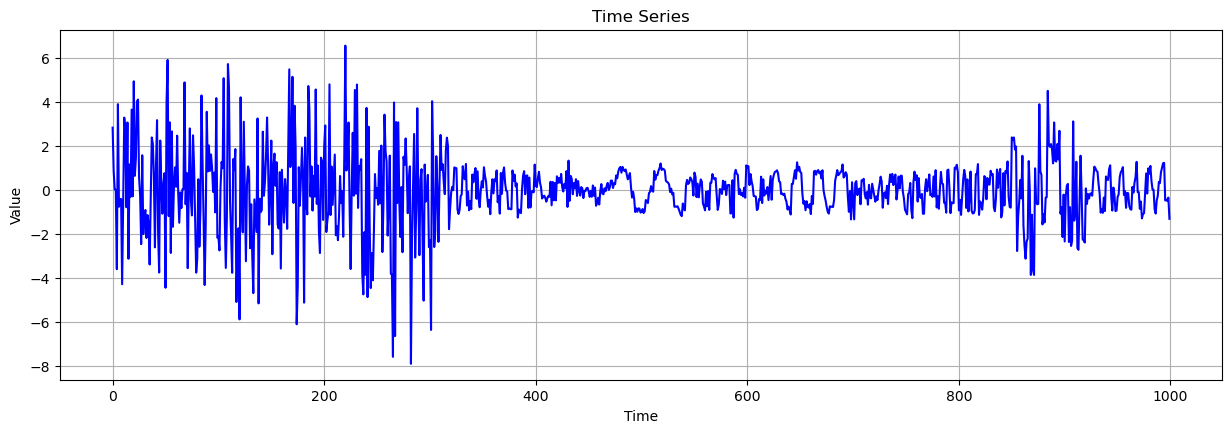

In [23]:
ts_visualization(follower_list_2[0][0])

In [24]:
follower_list_2[0][1]

[[320, 471, 622, 773, 924], [389, 540, 691, 842, 993]]

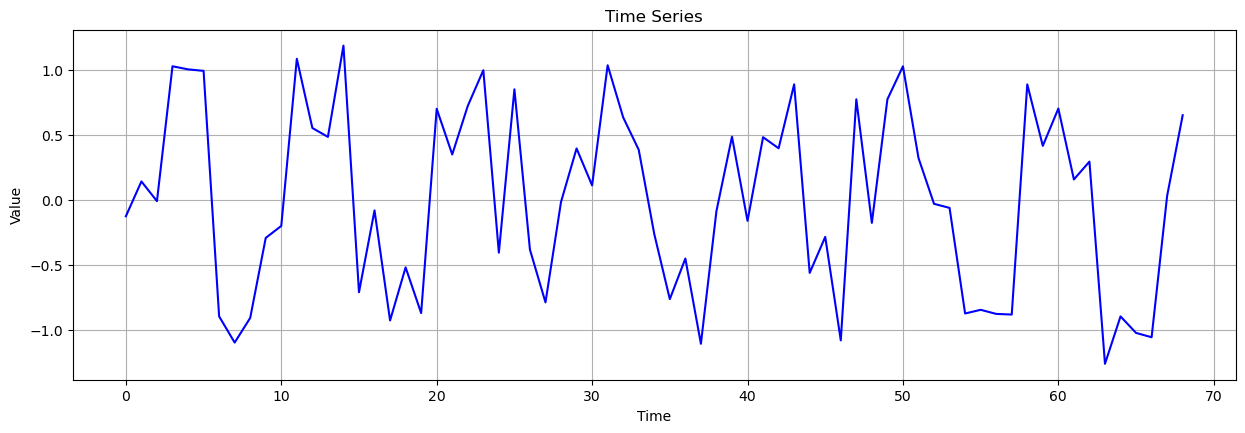

In [25]:
ts_visualization(follower_list_2[0][0][320:389])

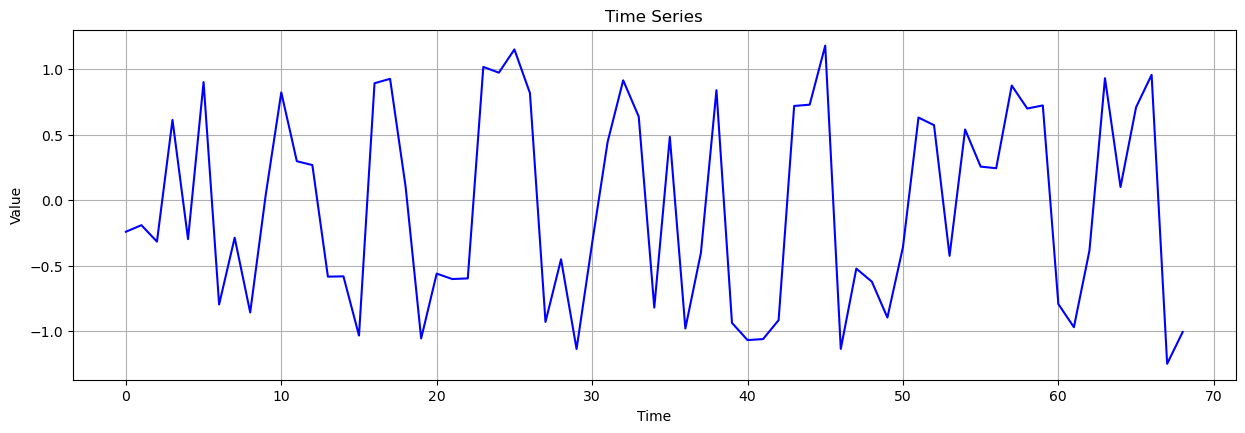

In [26]:
ts_visualization(follower_list_2[0][0][773:842])

# Methods

In [27]:
def following_relation_method(lead_ts,follow_ts,wd=300,gap=10):

    following_motif_index = [None,None]

    leader_mp,_   = matrixProfile.stamp(follow_ts,wd,lead_ts)
    follower_mp,_ = matrixProfile.stamp(lead_ts,wd,follow_ts)

    rmp = [follower_mp,leader_mp]

    for i in range(2):

        motif_percentile = 50-gap 
        
        motif_index = rmp[i] <np.percentile(rmp[i], motif_percentile)
        motif_index_mp = np.where(motif_index)[0] 

        following_motif_index[i] = motif_index_mp.copy()
        following_motif_index[i] = list(set(following_motif_index[i]))

    following_motif_index[1] = following_motif_index[1][:len(following_motif_index[0])]

    
    lead_result_value = np.mean(np.array(following_motif_index[0])-np.array(following_motif_index[1]))
    lead_result       = lead_result_value>0
    

    return lead_result,lead_result_value,following_motif_index


# Table2 for Dataset 1 & 2 
# Reediting Confusion Matrix 

In [28]:
def ground_truth(ts):
    gt_ts = ts[1]
    ground_truth = []
    for i in range(len(gt_ts[1])):
        ground_truth = ground_truth + list(range(gt_ts[0][i],gt_ts[1][i]+1))

    return np.array(ground_truth)


def Non(a_list):
    return np.setdiff1d(np.array(range(1001)), a_list)


def confusion_matrix(TP, TN, FP, FN):

    def f1_score(TP, TN, FP, FN):
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1 = 2 * (precision * recall) / (precision + recall)
        return precision,recall,f1
    
    precision,recall,f1 = f1_score(TP, TN, FP, FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    return TP,TN,FP,FN,precision,recall,f1,accuracy


def evaluate_a_pair_ts(leader,follower,seed=0,wd=30,gap=10):
    ground_truth_lead    = ground_truth(leader) 
    ground_truth_follow  = ground_truth(follower)

    ground_truth_lead = ground_truth_lead[:len(ground_truth_follow)]

    lead_ts   = (leader[0]).copy()
    follow_ts = (follower[0]).copy()

    np.random.seed(seed)
    result = following_relation_method(lead_ts,follow_ts,wd=wd,gap=gap)

    new_index_lead   = list(set(result[2][1]))
    new_index_follow = list(set(result[2][0]))

    new_index_lead = new_index_lead[:len(new_index_follow)]

    #==============================================

    # TP => #Point Method following match  #Point GT following
    existence_lead_TP = np.isin(new_index_lead, ground_truth_lead)
    existence_follow_TP = np.isin(new_index_follow, ground_truth_follow)
    TP = np.sum(existence_lead_TP)+np.sum(existence_follow_TP)
    
    # TN => #Point Method Non-following match  #Point GT Non-following
    existence_lead_TN = np.isin(Non(new_index_lead), Non(ground_truth_lead))
    existence_follow_TN = np.isin(Non(new_index_follow), Non(ground_truth_follow))
    TN = np.sum(existence_lead_TN)+np.sum(existence_follow_TN)
   
    # FP => #Point Method following match  #Point GT NON-following
    existence_lead_FP = np.isin(new_index_lead, Non(ground_truth_lead))
    existence_follow_FP = np.isin(new_index_follow, Non(ground_truth_follow))
    FP = np.sum(existence_lead_FP)+np.sum(existence_follow_FP)

    # FN => #Point Method NON-following NOT match #Point GT following
    existence_lead_FN = np.isin(Non(new_index_lead), ground_truth_lead)
    existence_follow_FN = np.isin(Non(new_index_follow), ground_truth_follow)
    FN = np.sum(existence_lead_FN)+np.sum(existence_follow_FN)

    #==============================================

    data = [TP, TN, FP, FN]

    #==============================================

    return np.array(data)


In [29]:
leader_list_2[0][1]

[[0, 151, 302, 453, 604, 755, 906], [69, 220, 371, 522, 673, 824, 975]]

In [30]:
true_false1 = np.array([0,0,0,0])
for i in range(1000):
    true_false1 += evaluate_a_pair_ts(leader_list_1[i],follower_list_1[i],seed=i,
                                      wd=30,gap=35)

true_false1

array([ 205270, 1663610,   86730,   46390])

In [31]:
true_false2 = np.array([0,0,0,0])
for i in range(1000):
    true_false2 += evaluate_a_pair_ts(leader_list_2[i],follower_list_2[i],seed=i,
                                      wd=30,gap=5)

true_false2

array([483741, 928039, 390259, 199961])

In [32]:
data = [
    confusion_matrix(true_false1[0],true_false1[1],true_false1[2],true_false1[3]),
    confusion_matrix(true_false2[0],true_false2[1],true_false2[2],true_false2[3]),

    confusion_matrix(true_false1[0]+true_false2[0],
                     true_false1[1]+true_false2[1],
                     true_false1[2]+true_false2[2],
                     true_false1[3]+true_false2[3]),
]

# Create DataFrame
df = pd.DataFrame(data, columns=['TP', 'TN', 'FP', 'FN','Precision','Recall','F1','Accuracy'])
df.index = ["Dataset1","Dataset2","Dataset1+2"]
df

,TP,TN,FP,FN,Precision,Recall,F1,Accuracy
Dataset1,205270,1663610,86730,46390,0.702979,0.815664,0.755141,0.933506
Dataset2,483741,928039,390259,199961,0.553479,0.707532,0.621096,0.705185
Dataset1+2,689011,2591649,476989,246351,0.590919,0.736625,0.655776,0.819346
